## 15/03/2021 

The paper with NP lemma shows very promising results which could potentially improve the performance yet again. Basically for the previous models, they were trained to recognise the important features of normal operation sound. this is good and all but it doesnt know anything about what is not normal. 

This is called an unsupervised learning model. A potential improvement is the use of a semi-supervised model. these models have some idea of what abnormal sound is like and can use this information to better separate the reconstruction errors from the normal cases and the abnormal cases. 

The first step of creating such a model is to create a way to set up a way to simulate some abnormal data while the model is training. 

This is a diffiult step, so i will first attempt a simpler version of this by the use of some fake data 

In [1]:
import torch 
import json 
import numpy as np 

# SubsetRandomSampler enables us to sample from the dataset. 
from sklearn.model_selection import train_test_split 

# dataloaders are good for not loading everything into memory and do it lazily
from torch.utils.data import SubsetRandomSampler, DataLoader,TensorDataset
from torch.autograd import Variable 

from tqdm import tqdm 
import torch.nn.functional as F
from torch import nn


In [2]:
DATA_PATH = "./data/synthetic/train_data.json"
VARIOUS_PATH = "./data/synthetic/various_data.json"

TEST_PATH = "./data/synthetic/test_data.json"
EPOCHS = 300
BATCH_SIZE = 150
SAVED_MODEL_PATH_E = "./models/model_paper_intermediate_E.pth"
SAVED_MODEL_PATH_D = "./models/model_paper_intermediate_D.pth"
SAVED_MODEL_PATH_G = "./models/model_paper_intermediate_G.pth"

## 15/03/2021 

The various classes and utility functions are defined as before.

everything is loaded onto the gpu for speed. 

a folder containing various noises of things dropping was created. 

Some data of items dropping was loaded into this folder 


In [3]:
def load_dataset(data_path):
    '''this loads the json file into dictionaries... still putting everything on memory '''
    with open(data_path,"r") as fp: 
        data = json.load(fp)
    X = np.array(data["data"])
    y = np.array(data["labels"])
    return X, y 

def to_device(data,device):
    ''' Loads everything to the GPU '''
    if isinstance(data, (list,tuple)):
        return [to_device(x, device)for x in data]
    else:
        return data.to(device, non_blocking = True)
    
class DeviceDataLoader():
    '''Creates a dataloader which automatically puts things to the device '''
    def __init__(self, dl, device):
        self.dl = dl 
        self.device = device 
    def __iter__(self):
        '''when used as an iterator this puts the batch onto the GPU before yielding it out'''
        for b in self.dl:
            yield to_device(b, self.device)
    def __len__(self):
        return len(self.dl)
    

# this is the training dataset containing only the normal sound samples
X,y=load_dataset(DATA_PATH)
X = torch.from_numpy(X).float()
y = torch.from_numpy(y).float()
dataset = TensorDataset(X,y)


# This contains various sounds, in this instance it is sound augmented by random dropping noises
X_v,y_v=load_dataset(VARIOUS_PATH)
X_v = torch.from_numpy(X_v).float()
y_v = torch.from_numpy(y_v).float()
dataset_v = TensorDataset(X_v,y_v)

# Test set contains normal sound samples, void sound samples at 1 snr and 0.5 snr.
X_test, y_test = load_dataset(TEST_PATH)
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()
testset = TensorDataset(X_test,y_test)

# Creating dataloaders from the datasets. 
train_dl = DataLoader(dataset, BATCH_SIZE, shuffle = True, drop_last=True)
test_dl = DataLoader(testset, BATCH_SIZE, shuffle = True, drop_last=True)
train_v_dl = DataLoader(dataset_v, BATCH_SIZE, shuffle = True, drop_last=True)

input_shape = dataset[0][0].shape
device = torch.device('cuda')

# decorating the dataloaders so that they load the data to the GPU automatically
train_dl = DeviceDataLoader(train_dl, device)
test_dl = DeviceDataLoader(test_dl, device)
train_v_dl = DeviceDataLoader(train_v_dl, device)

In [4]:
print(dataset_v[0])


(tensor([[[ -4.5665,  -4.2654,  -2.0106,  ...,  -7.3952, -30.4272, -14.4969],
         [ -6.3087,  -1.6650,  -4.4025,  ...,  -4.7651,  -8.7342, -11.2030],
         [-10.0447,   0.7506, -15.0677,  ...,  -2.3365,  -4.7488,  -8.5136],
         ...,
         [  7.1638,  14.0634,   6.9419,  ...,   1.2602,   6.0377,   3.9916],
         [  7.6228,  14.4680,   8.4123,  ...,   4.6743,   6.2258,   5.5481],
         [  7.7135,  16.0502,  15.1875,  ...,  10.8009,   9.3816,   9.7769]]]), tensor(0.))


In [5]:
latent_size = 9
# https://towardsdatascience.com/convolutional-autoencoders-for-image-noise-reduction-32fce9fc1763

class Encoder(nn.Module):
    '''Encoder is a convolutional'''
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,32,stride = 2, padding=1 , kernel_size=3)
        self.relu = nn.LeakyReLU(0.2)
        self.conv2 = nn.Conv2d(32,64, stride = 2, padding =1, kernel_size=3)
        self.conv3 = nn.Conv2d(64,128,stride =2, padding =1, kernel_size = 3)
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(4096,latent_size)

    
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.relu(out)
        out = self.conv3(out)        
        out = self.relu(out)
        out = self.flatten(out)
        out1 = self.relu(self.linear(out))
        out2 = self.relu(self.linear(out))
        
        return out1, out2
    
def reparameterise(mu, log_var, training_mode):
    if training_mode:
        std = torch.exp(0.5*log_var)
        eps = Variable(std.data.new(std.size()).normal_())
        sample = mu + (eps*std)
        return sample 
    else:
        return mu 
    
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(latent_size,4096)
        self.relu = nn.LeakyReLU(0.2)

        self.deconv3 = nn.ConvTranspose2d(128,64,stride =2, kernel_size = 3, padding =1,output_padding=1)
        self.deconv2 = nn.ConvTranspose2d(64,32,stride =2, kernel_size = 3,padding =1,output_padding=1)
        self.deconv1 = nn.ConvTranspose2d(32,1,stride =2, kernel_size = 3,padding =1,output_padding=1)
        
    def forward(self, xb):
        out = self.fc(xb)
        out = self.relu(out)
        out = out.reshape(-1,128,16,2)
        out = self.deconv3(out)
        out = self.relu(out)
        out = self.deconv2(out)
        out = self.relu(out)
        out = self.deconv1(out)
        return out

E_module = Encoder()
G_module = Decoder()
D_module = Decoder()

E_module.to(device)
G_module.to(device)
D_module.to(device)
E_module.load_state_dict(torch.load(SAVED_MODEL_PATH_E))
G_module.load_state_dict(torch.load(SAVED_MODEL_PATH_G))
D_module.load_state_dict(torch.load(SAVED_MODEL_PATH_G))

<All keys matched successfully>

In [6]:
from torchsummary import summary 
print(summary(E_module, input_size = (1,128,16)))
print(summary(G_module, input_size = (1,9)))
print(summary(D_module, input_size = (1,9)))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 32, 64, 8]             320
         LeakyReLU-2            [-1, 32, 64, 8]               0
            Conv2d-3            [-1, 64, 32, 4]          18,496
         LeakyReLU-4            [-1, 64, 32, 4]               0
            Conv2d-5           [-1, 128, 16, 2]          73,856
         LeakyReLU-6           [-1, 128, 16, 2]               0
           Flatten-7                 [-1, 4096]               0
            Linear-8                    [-1, 9]          36,873
         LeakyReLU-9                    [-1, 9]               0
           Linear-10                    [-1, 9]          36,873
        LeakyReLU-11                    [-1, 9]               0
Total params: 166,418
Trainable params: 166,418
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/

spectrogram shape:  torch.Size([150, 1, 128, 16])
output shape:  torch.Size([150, 9])
torch.Size([150, 9])


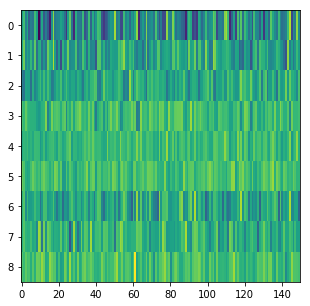

In [8]:

for images, labels in test_dl: 
    print("spectrogram shape: ", images.shape)
    out, _ = E_module(images)
    
    print("output shape: ", out.shape)
    break 
    
img = out.detach().cpu()
print(img.shape)
import matplotlib.pyplot as plt 

fig, ax = plt.subplots(1,1,figsize = (5,5))
ax.imshow(img.T, aspect = 'auto')


## 15/03/2021 

The NP loss was defined, this is based on the True positive rate and false positive rate. 

difficult to compute at inference time, so instead compute this approximately, and it will not affect training performance too much. 

The way to approximate this is given in the unsupervised learning anomaly detection using neyman pearson lemma paper. 

Involves calculating the mse error of the anomalous and normal sounds, taking a mean and subtracting phi from it, beofre feeding it into a sigmoid function. the value of phi can be optimised. 

In [54]:



def loss_function(images, reconstructed, mu,logvar):
    mse = nn.MSELoss()
    mse_loss = mse(images,reconstructed)
    
    KLD = -0.5*torch.sum(1+logvar - mu.pow(2) - logvar.exp())/(BATCH_SIZE*128*16)
    return KLD+mse_loss

# The np loss is defined as the TPR minus the FPR. We cannot compute this exactly in an efficient manner so we can instead 
def NP_loss(images_u, reconstructed_u, images_a, reconstructed_a, phi):
    mse1 = nn.MSELoss(reduction ="none")
    m_a = torch.mean(mse1(images_a, reconstructed_a), dim =(1,2,3))
    m_u = torch.mean(mse1(images_u, reconstructed_u), dim =(1,2,3))
    #print(m_a,m_u, phi)
    tpr = torch.mean(torch.sigmoid(m_a-phi))
    fpr = torch.mean(torch.sigmoid(m_u-phi))
    return fpr - tpr 
    

## Now start training and see what the resulting image would look like 


In [55]:
e_opt= torch.optim.Adam(E_module.parameters(), lr = 0.0002)
d_opt= torch.optim.Adam(D_module.parameters(), lr = 0.0002)
g_opt= torch.optim.Adam(G_module.parameters(), lr = 0.0002)





In [56]:
loss_list = []
EPOCHS = 200
mse = nn.MSELoss(reduction = "none")

for epoch in range(EPOCHS):
    for (images, _),(images_v, _v) in zip(train_dl,train_v_dl):
        mu, logvar = E_module(images_v)
        z = reparameterise(mu, logvar, True)
        reconstructed_a = G_module(z)
        temp = reconstructed_a.clone()

        loss = loss_function(images_v, reconstructed_a, mu, logvar)
        
        e_opt.zero_grad()
        g_opt.zero_grad()
        loss.backward()
        e_opt.step()
        g_opt.step()
    
    
        # Now do the second training step 
        reconstructed_a = temp.detach()
        
        latents, _ = E_module(images)
        recon_normal = D_module(latents)

        latents_anomalous, _= E_module(reconstructed_a)
        recon_anomalous = D_module(latents_anomalous)

        
        phi = min(torch.mean(mse(reconstructed_a.clone(), recon_anomalous.clone()), dim =(1,2,3)))
        
        loss_np = NP_loss(images, recon_normal, reconstructed_a, recon_anomalous, phi)
        
        e_opt.zero_grad()
        d_opt.zero_grad()
        loss_np.backward()
        e_opt.step()
        d_opt.step()
           
        
    loss_list.append(np.sum(loss.item()))
    
    print('epoch [{}/{}], loss:{:.4f}, loss_np{:.4f}'.format(epoch+1, EPOCHS, loss.item(), loss_np.item()))

        


epoch [1/200], loss:43.2374, loss_np-0.1033
epoch [2/200], loss:35.7538, loss_np-0.0432
epoch [3/200], loss:36.3176, loss_np-0.0900
epoch [4/200], loss:34.2145, loss_np-0.0633
epoch [5/200], loss:34.2994, loss_np-0.0767
epoch [6/200], loss:33.4961, loss_np-0.1033
epoch [7/200], loss:33.6450, loss_np-0.0543
epoch [8/200], loss:34.1604, loss_np-0.0900
epoch [9/200], loss:33.1029, loss_np-0.0752
epoch [10/200], loss:33.3304, loss_np-0.0710
epoch [11/200], loss:33.3303, loss_np-0.1233
epoch [12/200], loss:33.0867, loss_np-0.0889
epoch [13/200], loss:33.5335, loss_np-0.1300
epoch [14/200], loss:32.9164, loss_np-0.0636
epoch [15/200], loss:33.0003, loss_np-0.1033
epoch [16/200], loss:32.8150, loss_np-0.0963
epoch [17/200], loss:32.8767, loss_np-0.1167
epoch [18/200], loss:32.8452, loss_np-0.0633
epoch [19/200], loss:33.1708, loss_np-0.0832
epoch [20/200], loss:32.3282, loss_np-0.0574
epoch [21/200], loss:32.5026, loss_np-0.0841
epoch [22/200], loss:33.0552, loss_np-0.0966
epoch [23/200], los

epoch [182/200], loss:31.0180, loss_np-0.9967
epoch [183/200], loss:30.4632, loss_np-0.9700
epoch [184/200], loss:30.5356, loss_np-0.9833
epoch [185/200], loss:30.3643, loss_np-0.9965
epoch [186/200], loss:30.4771, loss_np-0.9900
epoch [187/200], loss:30.7412, loss_np-0.9900
epoch [188/200], loss:30.7272, loss_np-0.9967
epoch [189/200], loss:30.4846, loss_np-0.9956
epoch [190/200], loss:31.1203, loss_np-0.9967
epoch [191/200], loss:30.6158, loss_np-0.9946
epoch [192/200], loss:30.4679, loss_np-0.9913
epoch [193/200], loss:30.7352, loss_np-0.9961
epoch [194/200], loss:30.4613, loss_np-0.9967
epoch [195/200], loss:30.5780, loss_np-0.9900
epoch [196/200], loss:30.2935, loss_np-0.9967
epoch [197/200], loss:30.2116, loss_np-0.9967
epoch [198/200], loss:30.1941, loss_np-0.9967
epoch [199/200], loss:30.2480, loss_np-0.9967
epoch [200/200], loss:30.2590, loss_np-0.9652


In [64]:
torch.save(E_module.state_dict(), SAVED_MODEL_PATH_E)
torch.save(D_module.state_dict(), SAVED_MODEL_PATH_D)
torch.save(G_module.state_dict(), SAVED_MODEL_PATH_G)



spectrogram shape:  torch.Size([150, 1, 128, 16])
output shape:  torch.Size([150, 1, 128, 16])
torch.Size([128, 16])


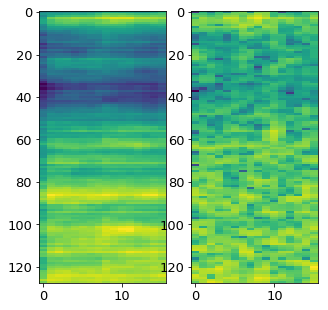

In [57]:

for images, labels in train_dl: 
    print("spectrogram shape: ", images.shape)
    mu, logvar = E_module(images)
    z = reparameterise(mu, logvar, False)

    out = G_module(z)    
    print("output shape: ", out.shape)
    break 
    
img = out[1][0].detach().cpu()
print(img.shape) 

import matplotlib.pyplot as plt 
fig, axs = plt.subplots(1,2,figsize = (5,5))
axs[0].imshow(img, aspect = 'auto')
axs[1].imshow(images[1][0].detach().cpu(), aspect = 'auto')

In [10]:
out_list = [[] for i in range(3)]
imgs = [[] for i in range(3)]
mse_per_image = nn.MSELoss(reduction='none')
for images, labels in test_dl:
    print(images.shape)
    mu, logvar = E_module(images)
    z = reparameterise(mu, logvar, False) 
    out = G_module(z)    
    losses = torch.sum(mse_per_image(images, out).detach().cpu(), dim =(1,2,3))/(images.shape[-1]*images.shape[-2])
    losses = losses.numpy()
    for i in range(len(images)):
        out_list[int(labels[i].detach().cpu())].append(losses[i])
        imgs[int(labels[i].detach().cpu())].append(images[i])


torch.Size([150, 1, 128, 16])
torch.Size([150, 1, 128, 16])
torch.Size([150, 1, 128, 16])
torch.Size([150, 1, 128, 16])


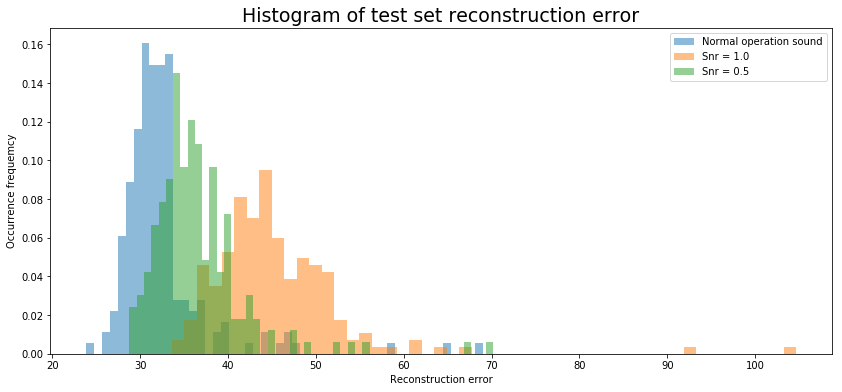

torch.Size([1, 128, 16])


In [12]:

fig, ax = plt.subplots(1,1,figsize = (14,6))

ax.title.set_text("Histogram of test set reconstruction error")
ax.title.set_fontsize(19)
labels = ["Normal operation sound", "Snr = 1.0", "Snr = 0.5"]

for i in range(3):
    ax.hist(bins = 50, x=out_list[i], alpha = 0.5, label = labels[i], density = True)

ax.set_xlabel("Reconstruction error")
ax.set_ylabel("Occurrence frequemcy")
ax.legend()
plt.show()

min_img = imgs[1][out_list[1].index(min(out_list[1]))]
print(np.shape(min_img))


## 16/03/2021 
## analysis 
the performance in this case got a lot worse. looking at the shape of the normal sound reconstruction error, we can see that the distribution became not very normal, with a large amount of outliers. The part around 30 seems to be more steep. This means for at least a certain group of inputs, the output became more confident that the sound is normal. However, for perhaps the part of the normal sound that sounded like the generated positive case, this broke down as the training procedure now confuses the model to reconstruct the these according to the similar positive examples seen during training. This could be due to a low snr on when constructing these training positves, meaning they were not suffuciently different from the normal sound. Increasing the 

torch.Size([1, 128, 16])
torch.Size([128, 16])


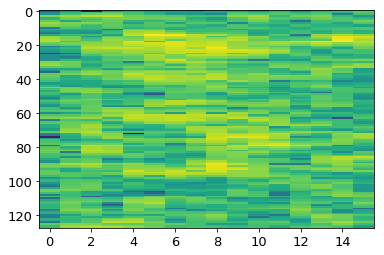

In [61]:
min_img = imgs[1][out_list[1].index(min(out_list[1]))]
print(np.shape(min_img))
im = min_img.detach().cpu().squeeze()
print(np.shape(im))
plt.imshow(im, aspect = "auto")

The difference is 0.267520484855091


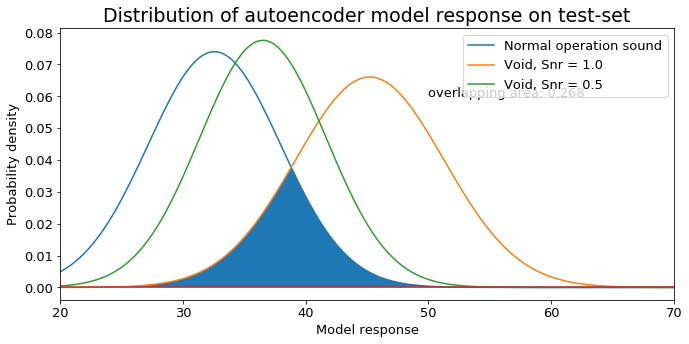

In [62]:
import scipy.integrate
from scipy.stats import norm
fig, ax = plt.subplots(1,1,figsize = (11,5))
integrate = scipy.integrate.quad
ax.title.set_text("Distribution of autoencoder model response on test-set")
ax.title.set_fontsize(19)
labels = ["Normal operation sound", "Void, Snr = 1.0", "Void, Snr = 0.5"]
x = np.linspace(20,140,800)
SMALL_SIZE = 13
MEDIUM_SIZE = 13
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
 
for i in range(len(out_list)):
    truncated = [out_list[i][j] if out_list[i][j]<=65 else 65 for j in range(len(out_list[i]))]
    if i ==1: 
        m_old = m
        s_old = s
        y_old = y
    m = np.mean(truncated)
    s = np.sqrt(np.var(truncated))
    y = norm.pdf(x,m,s)

    if i==1:
        under_fun = lambda x: min(norm.pdf(x,m,s), norm.pdf(x,m_old, s_old))
        diff = integrate(under_fun, 10,60)
        print(f"The difference is {diff[0]}")
        y_min = [min(y[i],y_old[i]) for i in range(len(y))]
        ax.fill_between(x, y_min)
    ax.plot(x,y, label = labels[i])
    


ax.plot(x, [0 for i in range(len(x))])
ax.set_xlim([20,70])
ax.set_xlabel("Model response")
ax.set_ylabel("Probability density")
ax.text(50,0.06,f"overlapping area: {diff[0]:.3f}")
ax.legend()
plt.show()


## 16/03/2021 

A huge overlapping area was observed in this case.

This again shows that the model is quite confused in various regions 

plot the roc to quantitatively measure this 

The aoc score is 0.959 for snr =1
The aoc score is 0.809 for snr =0.5


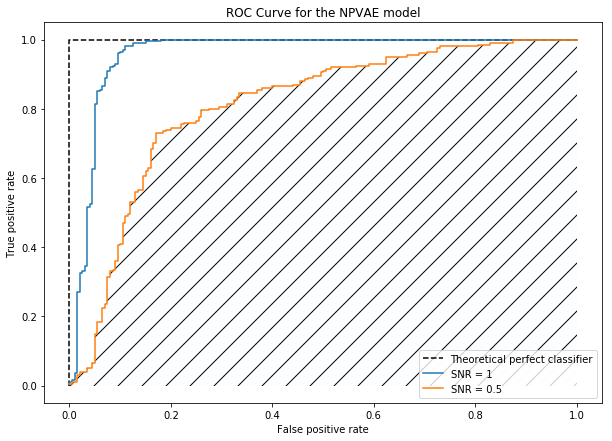

In [20]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

scores1 = out_list[0]+out_list[1]
y1 = [0 for i in range(len(out_list[0]))]+[1 for i in range(len(out_list[1]))]
fpr1, tpr1, thresholds1 = roc_curve(y1, scores1, pos_label = 1)

aoc_snr1 = roc_auc_score(y1,scores1)
print(f"The aoc score is {aoc_snr1:.3f} for snr =1")

scores2 = out_list[0]+out_list[2]
y2 = [0 for i in range(len(out_list[0]))]+[1 for i in range(len(out_list[2]))]
fpr2, tpr2, thresholds2= roc_curve(y2, scores2, pos_label = 1)

aoc_snr2 = roc_auc_score(y2,scores2)
print(f"The aoc score is {aoc_snr2:.3f} for snr =0.5")

fig, ax = plt.subplots(1,1, figsize = (10,7))

ax.title.set_text("ROC Curve for the NPVAE model")
ax.set_xlabel("False positive rate")
ax.set_ylabel("True positive rate")
ax.plot(fpr1,[0]+[1 for i in range(len(fpr1)-1)],linestyle = "dashed", markersize = 7, label = "Theoretical perfect classifier", c = "black")

ax.plot(fpr1, tpr1, label = "SNR = 1")
ax.plot(fpr2, tpr2, label = "SNR = 0.5")
ax.fill_between(fpr2, tpr2, hatch = "/", alpha = 0.01)

ax.legend()

## 16/03/2021 

The ROC curve shows that the model is not performing well, and is struggling with false positives at the earlier regions. The shape is also quite different to what was observed before. This is not too promising but will continue on with other parts of the build. 

when visualised over the 10 seconds sample containing 5 voids, it again struggled with the t = 7.5 region. 

In [14]:
import librosa

test_piece, sr = librosa.load("./data/synthetic/7_with_void.wav")

score = []
i =0 
my_len = 16*512-1
while i<len(test_piece)-my_len:
    piece = test_piece[i:i+my_len]
    xt  = librosa.power_to_db(librosa.feature.melspectrogram(piece, n_mels = 128, fmax = 1024))
    xt = torch.tensor(xt).float()
    xt = torch.unsqueeze(xt,0)
    xt = torch.unsqueeze(xt,0)
    xt = xt.to(device)
    mu, logvar = E_module(xt)
    z = reparameterise(mu, logvar, False)

    out = G_module(z)        
    loss = mse_per_image(out, xt)
    
    score.append(float(torch.sum(loss.detach().cpu())/(xt.shape[-1]*xt.shape[-2])))
    i+= 512
    


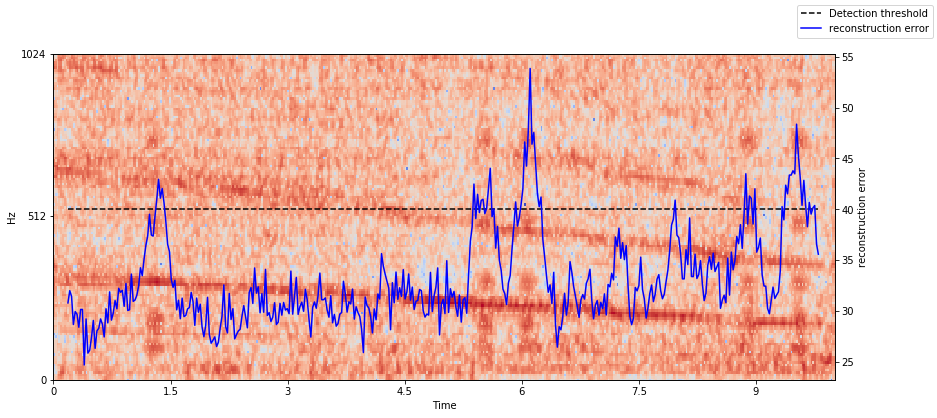

In [17]:
import librosa.display
x =[]
test_xt = librosa.power_to_db(librosa.feature.melspectrogram(test_piece, n_mels =128, fmax= 1024))
fig = plt.gcf()
fig.set_size_inches(14,6)
ax = plt.subplot()

ax2 = ax.twinx()
librosa.display.specshow(test_xt, fmax = 1024, y_axis = "mel", ax = ax, x_axis = 'time')
for i in range(len(score)):
    x.append((i+8)*(512/sr))
ax2.set_ylabel("reconstruction error")
ax2.plot(x,[40 for i in range(len(x))],linestyle = "dashed", markersize = 7, label = "Detection threshold", c = "black")
ax2.plot(x,score, c="blue", label = "reconstruction error")
fig.legend()

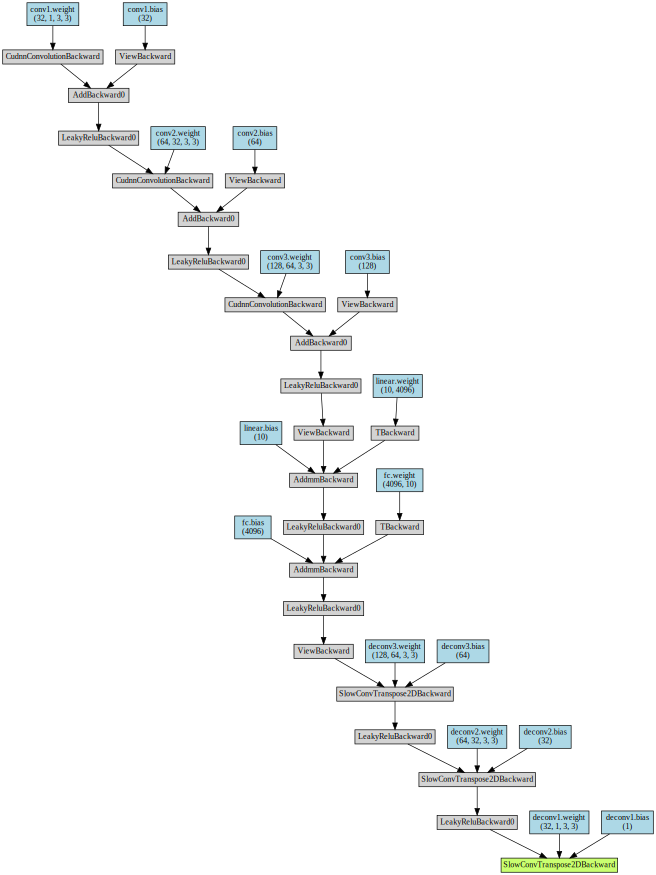

In [161]:
from torchviz import make_dot 
make_dot(recons, params = dict(autoencoder.named_parameters()))

In [163]:
from torch.utils.tensorboard import SummaryWriter 
writer = SummaryWriter("runs/ae_experiment_1")

In [169]:
writer.add_graph(autoencoder,images)


In [17]:
(0.98**2*0.03)/(0.04**2*0.97+0.03*0.98**2)

0.9488868396785667